<a href="https://colab.research.google.com/github/JayJihyunKim/workbooks/blob/main/MLP_Basic_Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Multi-layer Perceptron
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()

import torch
import torch.nn as nn
from torch import optim

X = digits.data
Y = digits.target

In [3]:
model = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,10),
)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.int64)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
losses = []

for epoch in range(100):
  optimizer.zero_grad()
  y_pred = model(X)
  loss = loss_fn(y_pred, Y)
  loss.backward()
  optimizer.step()

  print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, 100, loss.item()))

  losses.append(loss.item())



Epoch    0/100 Cost: 2.571029
Epoch    1/100 Cost: 2.489310
Epoch    2/100 Cost: 2.420936
Epoch    3/100 Cost: 2.362861
Epoch    4/100 Cost: 2.313284
Epoch    5/100 Cost: 2.269890
Epoch    6/100 Cost: 2.231122
Epoch    7/100 Cost: 2.196110
Epoch    8/100 Cost: 2.163525
Epoch    9/100 Cost: 2.132035
Epoch   10/100 Cost: 2.101027
Epoch   11/100 Cost: 2.069925
Epoch   12/100 Cost: 2.038405
Epoch   13/100 Cost: 2.006643
Epoch   14/100 Cost: 1.974649
Epoch   15/100 Cost: 1.942647
Epoch   16/100 Cost: 1.910621
Epoch   17/100 Cost: 1.878643
Epoch   18/100 Cost: 1.846989
Epoch   19/100 Cost: 1.816091
Epoch   20/100 Cost: 1.785633
Epoch   21/100 Cost: 1.755388
Epoch   22/100 Cost: 1.725386
Epoch   23/100 Cost: 1.695063
Epoch   24/100 Cost: 1.664199
Epoch   25/100 Cost: 1.632564
Epoch   26/100 Cost: 1.600139
Epoch   27/100 Cost: 1.567086
Epoch   28/100 Cost: 1.533620
Epoch   29/100 Cost: 1.499681
Epoch   30/100 Cost: 1.465167
Epoch   31/100 Cost: 1.430232
Epoch   32/100 Cost: 1.395218
Epoch   33

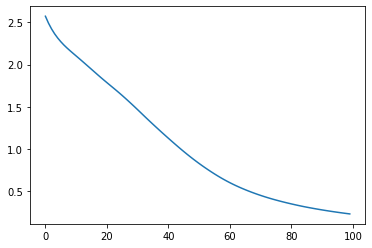

In [4]:
plt.plot(losses)

In [6]:
#MLP 코딩개선

!pip install pytorch-ignite

     |████████████████████████████████| 184kB 4.5MB/s 


In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#손글씨 데이터 로드
from sklearn.datasets import load_digits
digits= load_digits()

#torch 관련
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

#ignite 관련
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
# from ignite.handlers import ModelCheckpoint, EarlyStopping



In [47]:
X = digits.data
Y = digits.target
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.int64)

ds = TensorDataset(X,Y)

train_loader = DataLoader(ds, batch_size=64, shuffle=True)
val_loader = DataLoader(ds, batch_size=64, shuffle=True)


In [48]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()

    self.fc = nn.Sequential(
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,10)
    )

  def forward(self,x):
    x = self.fc(x)

    return F.log_softmax(x,dim=1)

In [49]:
model = MLP()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)
metrics = {
    'accuracy': Accuracy(),
    'nll' : Loss(loss_fn),
    'cm' : ConfusionMatrix(num_classes=10)                                                                                                                    
}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'accuracy':[], 'loss':[]}
validation_history={'accuracy':[], 'loss':[]}
last_epoch=[]


In [50]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
  train_evaluator.run(train_loader)
  metrics = train_evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['nll']
  last_epoch.append(0)
  training_history['accuracy'].append(accuracy)
  training_history['loss'].append(loss)
  print("Training Results - Epoch: {} Avg accuracy: {:.4f} Avg loss: {:.4f}".format(trainer.state.epoch, accuracy, loss))

def log_validation_results(trainer):
  val_evaluator.run(val_loader)
  metrics = val_evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['nll']
  validation_history['accuracy'].append(accuracy)
  validation_history['loss'].append(loss)
  print("Validation Results - Epoch: {} Avg accuracy: {:.4f} Avg loss: {:.4f}".format(trainer.state.epoch, accuracy, loss))

trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

In [51]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
  val_evaluator.run(val_loader)
  metrics = val_evaluator.state.metrics
  cm = metrics['cm']
  cm = cm.numpy()
  cm = cm.astype(int)
  classes = ['0','1','2','3','4','5','6','7','8','9']
  fig, ax = plt.subplots(figsize=(10,10))
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, fmt="d")
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels') 
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels(classes,rotation=90)
  ax.yaxis.set_ticklabels(classes,rotation=0)

Training Results - Epoch: 1 Avg accuracy: 50.3061 Avg loss: 1.7728
Validation Results - Epoch: 1 Avg accuracy: 50.3061 Avg loss: 1.7728
Training Results - Epoch: 2 Avg accuracy: 71.2298 Avg loss: 1.1214
Validation Results - Epoch: 2 Avg accuracy: 71.2298 Avg loss: 1.1214
Training Results - Epoch: 3 Avg accuracy: 85.7540 Avg loss: 0.6754
Validation Results - Epoch: 3 Avg accuracy: 85.7540 Avg loss: 0.6754
Training Results - Epoch: 4 Avg accuracy: 90.3172 Avg loss: 0.4191
Validation Results - Epoch: 4 Avg accuracy: 90.3172 Avg loss: 0.4191
Training Results - Epoch: 5 Avg accuracy: 91.4858 Avg loss: 0.3126
Validation Results - Epoch: 5 Avg accuracy: 91.4858 Avg loss: 0.3126
Training Results - Epoch: 6 Avg accuracy: 93.7674 Avg loss: 0.2397
Validation Results - Epoch: 6 Avg accuracy: 93.7674 Avg loss: 0.2397
Training Results - Epoch: 7 Avg accuracy: 94.8804 Avg loss: 0.1993
Validation Results - Epoch: 7 Avg accuracy: 94.8804 Avg loss: 0.1993
Training Results - Epoch: 8 Avg accuracy: 95.937

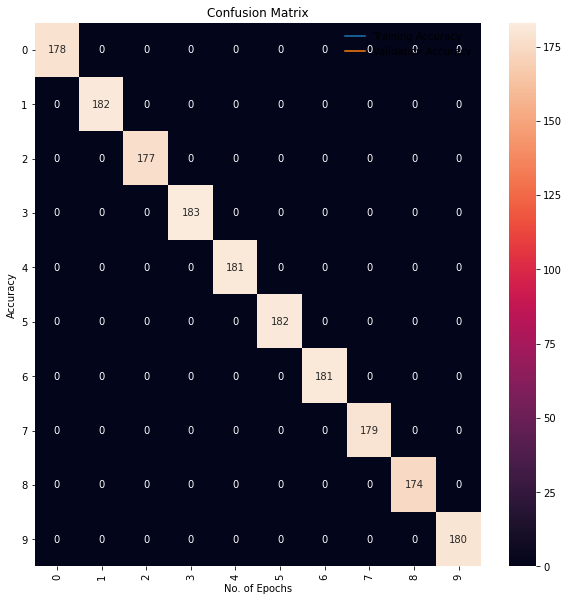

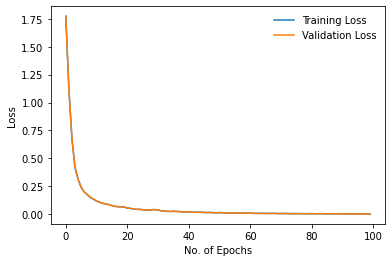

In [52]:
trainer.run(train_loader, max_epochs=epochs)

plt.plot(training_history['accuracy'],label="Training Accuracy")
plt.plot(validation_history['accuracy'],label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()